[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Masao-Taketani/JPN-EN-Transformer-translator/blob/master/notebooks/test/train.ipynb)

In [1]:
!pip install sentencepiece

     |████████████████████████████████| 1.1MB 7.9MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [51]:
import sentencepiece as spm
import tensorflow as tf
from tensorflow.data.experimental import AUTOTUNE
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import time

In [4]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64
jpn_sp_model = "drive/My Drive/deep_learning_models/JPN-EN-Transformer-translator/jpn_spm.model"
en_sp_model = "drive/My Drive/deep_learning_models/JPN-EN-Transformer-translator/en_spm.model"
jpn_sp = spm.SentencePieceProcessor()
en_sp = spm.SentencePieceProcessor()
jpn_sp.Load(jpn_sp_model)
en_sp.Load(en_sp_model)

True

In [5]:
def read_data(fpath):
  with open(fpath, "r") as f:
    return f.read()

def get_data(fpath):
  data = read_data(fpath)
  data_list = []
  for line in data.split("\n"):
    data_list.append(line)
  return data_list

def get_max_len_and_list(fpath):
  data = read_data(fpath)
  max_len = 0
  li = []
  for line in data.split("\n"):
    li.append(line)
    if max_len < len(line):
      max_len = len(line)
  return max_len, li

In [6]:
jpn_path = "drive/My Drive/deep_learning_models/JPN-EN-Transformer-translator/jpn_data.txt"
en_path = "drive/My Drive/deep_learning_models/JPN-EN-Transformer-translator/en_data.txt"
jpn_data = get_data(jpn_path)
en_data = get_data(en_path)
train_jpn, val_jpn, train_en, val_en = train_test_split(jpn_data, en_data, test_size=0.05)

print("train size:", len(train_jpn), "validation size:", len(val_jpn))

train size: 142298 validation size: 7490


In [7]:
# When you have tf.Tensor(string) and .numpy() method is used inside of the tf.py_function, 
# it is converted to just a string. Not a numpy.
def encode(jpn, en):
  jpn_enc = [jpn_sp.PieceToId("<s>")] + jpn_sp.EncodeAsIds(jpn.numpy()) + [jpn_sp.PieceToId("</s>")]
  en_enc = [en_sp.PieceToId("<s>")] + en_sp.EncodeAsIds(en.numpy()) + [en_sp.PieceToId("</s>")]
  return jpn_enc, en_enc

def tf_encode(jpn, en):
  result_jpn, result_en = tf.py_function(encode, [jpn, en], [tf.int64, tf.int64])
  result_jpn.set_shape([None])
  result_en.set_shape([None])
  return result_jpn, result_en

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_jpn, train_en))
train_dataset = train_dataset.map(tf_encode)
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_jpn, val_en))
val_dataset = val_dataset.map(tf_encode)
val_dataset = val_dataset.padded_batch(BATCH_SIZE)

In [9]:
# Positinal Encoding
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array: 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array: 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
  # add the new dim to the first dimension
  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

In [10]:
pos_encoding = positional_encoding(position=50, d_model=512)
print(pos_encoding.shape)

(1, 50, 512)


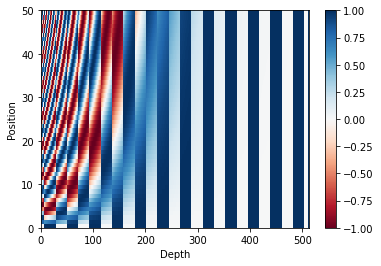

In [11]:
plt.pcolormesh(pos_encoding[0], cmap="RdBu")
plt.xlabel("Depth")
plt.xlim((0, 512))
plt.ylabel("Position")
plt.colorbar()
plt.show()

In [12]:
# Masking
# The mask indicates where pad value 0 is present, it outputs a 1 at thoese
# locations. Otherwise 0.
def create_padding_mask(seq):
  # tf.math.equal(x, y): Returns the truth value of (x == y) element-wise.
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

  # add extra dimensions to add the padding to the attention logits
  # returned shape: (batch_size, 1, 1, seq_len)
  return seq[:, tf.newaxis, tf.newaxis, :]

In [13]:
x = tf.constant([[7, 6, 0, 0, 0], [1, 2, 3, 0, 0], [4, 5, 9, 10, 0]])
print("shape of x:", x.shape)
create_padding_mask(x)

shape of x: (3, 5)


<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 1.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[0., 0., 0., 0., 1.]]]], dtype=float32)>

In [14]:
def create_look_ahead_mask(seq_len):
  """
  tf.linalg.band_part(input, num_lower, num_upper) 
  ([used to be]tf.matrix_band_part)
  (e.g) tf.linalg.band_part(tf.ones((3, 3)), -1, 0)
  <tf.Tensor: shape=(3, 3), dtype=float32, numpy=
  array([[1., 0., 0.],
         [1., 1., 0.],
         [1., 1., 1.]], dtype=float32)>
  [reference]https://dev.classmethod.jp/articles/tensorflow-matrixbandpart/
  """
  mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  # returned shape: (seq_len, seq_len)
  return mask

In [15]:
tf.linalg.band_part(tf.ones((3, 3)), -1, 0)

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1., 0., 0.],
       [1., 1., 0.],
       [1., 1., 1.]], dtype=float32)>

In [16]:
# Scaled Dot-Product Attention
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v
  The mask has different shapes depending on its type(padding or look ahead)
  but it must be boradcastable for addition.
  Padding is used for self-attention and encoder-decoder attention.
  Look ahead is used for encoder-decoder attention.

  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable
      to (..., seq_len_q, seq_len_k). Defaults to None.

  Returns:
    output, attention_weights
  """

  # shape: (..., seq_len_q, seq_len_k)
  matmul_qk = tf.matmul(q, k, transpose_b=True)

  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if not mask:
    scaled_attention_logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  # As the softmax normalization is done on k, its values decide the amount of 
  # importance given to Q.
  # shape: (..., seq_len_q, seq_len_k)
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
  # shape: (..., seq_len_q, depth_v)
  output = tf.matmul(attention_weights, v)

  return output, attention_weights

In [17]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(q, k, v, 0)
  print("Attention weights are:")
  print(temp_attn)
  print("Output is:")
  print(temp_out)

In [18]:
np.set_printoptions(suppress=True)

# shape: (4, 3)
temp_k = tf.constant([[10, 0, 0],
                      [0, 10, 0],
                      [0, 0, 10],
                      [0, 0, 10]], dtype=tf.float32)
# shape: (4, 2) 
temp_v = tf.constant([[1, 0],
                      [10, 0],
                      [100, 5],
                      [1000, 6]], dtype=tf.float32)

In [19]:
# This `query` aligns with the second `key`,
# so the second 'value' is returned.
# shape: (1, 3)
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [20]:
# This query aligns with a repeated key (third and fourth),
# so all associated values get averaged.
# shape: (1, 3)
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [21]:
# this query aligns equally with the first and second key,
# so their values get averaged.
# shape: (1, 3)
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


In [22]:
temp_q = tf.constant([[2, 3, 5]], dtype=tf.float32)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.00000002 0.00000483 0.49999762 0.49999762]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[549.99744    5.499974]], shape=(1, 2), dtype=float32)


In [23]:
# pass all the query together
temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0], [2, 3, 5]], dtype=tf.float32)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor(
[[0.         0.         0.5        0.5       ]
 [0.         1.         0.         0.        ]
 [0.5        0.5        0.         0.        ]
 [0.00000002 0.00000483 0.49999762 0.49999762]], shape=(4, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.         5.5     ]
 [ 10.         0.      ]
 [  5.5        0.      ]
 [549.99744    5.499974]], shape=(4, 2), dtype=float32)


In [24]:
# Multi-Head Attention
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is 
    (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    # all shapes: (batch_size, seq_len, d_model)
    q = self.wq(q)
    k = self.wk(k)
    v = self.wv(v)

    # all shapes: (batch_size, num_heads, seq_len, depth)
    q = self.split_heads(q, batch_size)
    k = self.split_heads(k, batch_size)
    v = self.split_heads(v, batch_size)

    # scaled_attention.shape == (batch_size, num_heads, seq_len, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len, seq_len)
    scaled_attention, attention_weights = scaled_dot_product_attention(q, 
                                                                       k, 
                                                                       v, 
                                                                       mask)
    # shape: (batch_size, seq_len, num_heads, depth)
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
    # shape: (batch_size, seq_len, d_model)
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))
    # shape: (batch_size, seq_len, d_model)
    output = self.dense(concat_attention)

    return output, attention_weights

In [25]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
# shape: (batch_size, seq_len, d_model)
y = tf.random.uniform((1, 60, 512))
out, attn = temp_mha(v=y, k=y, q=y, mask=0)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

In [26]:
# Point-Wise Feed-Forward Network
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([tf.keras.layers.Dense(dff, 
                                                    activation="relu"), #(batch_size, seq_len, dff)
                              tf.keras.layers.Dense(d_model)]) # (batch_size, seq_len, d_model)

In [27]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

In [28]:
# Encoder Layer
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    # point_wise_feed_forward_netowork is a function
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    """
    tf.keras.layers.Dropout(rate):
    rate: Float between 0 and 1. Fraction of the input units to drop.
    The Dropout layer randomly sets input units to 0 with a frequency of rate 
    at each step during training time, which helps prevent overfitting. 
    Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over 
    all inputs is unchanged."""
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):
    # shape: (batch_size, input_seq_len, d_model)
    atten_output, _ = self.mha(x, x, x, mask)
    atten_output = self.dropout1(atten_output, training=training)
    # shape: (batch_size, input_seq_len, d_model)
    out1 = self.layernorm1(x + atten_output)

    # shape: (batch_size, input_seq_len, d_model)
    ffn_output = self.ffn(out1)
    ffn_output = self.dropout2(ffn_output, training=training)
    # shape: (batch_size, input_seq_len, d_model)
    out2 = self.layernorm2(out1 + ffn_output)

    return out2

In [29]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)
sample_encoder_layer_output = sample_encoder_layer(x=tf.random.uniform((64, 43, 512)), 
                                                   training=False,
                                                   mask=0)
sample_encoder_layer_output.shape

TensorShape([64, 43, 512])

In [30]:
# Decoder Layer
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)
    # shape: (batch_size, target_seq_len, d_model)
    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(x + attn1)
    # shape: (batch_size, target_seq_len, d_model)
    attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
    attn2 = self.dropout2(attn2, training=training)
    # shape: (batch_size, target_seq_len, d_model)
    out2 = self.layernorm2(out1 + attn2)

    # shape: (batch_size, target_seq_len, d_model)
    ffn_output = self.ffn(out2)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(out2 + ffn_output)

    return out3, attn_weights_block1, attn_weights_block2

In [31]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(tf.random.uniform((64, 50, 512)),
                                                         sample_encoder_layer_output,
                                                         training=False,
                                                         look_ahead_mask=0,
                                                         padding_mask=0)
sample_decoder_layer_output.shape

TensorShape([64, 50, 512])

In [32]:
# Encoder part
class Encoder(tf.keras.layers.Layer):
  def __init__(self, 
               num_layers, 
               d_model, 
               num_heads, 
               dff, 
               input_vocab_size, 
               maximum_position_encoding, 
               rate=0.1):
    
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding,
                                            self.d_model)
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate)
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):
    seq_len = tf.shape(x)[1]

    # adding embedding and position encoding.
    # shape: (batch_size, input_seq_len, d_model)
    x = self.embedding(x)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    x = self.dropout(x, training=training)
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)
      
    # shape: (batch_size, input_seq_len, d_model)
    return x

In [33]:
sample_encoder = Encoder(num_layers=2, 
                         d_model=512, 
                         num_heads=8, 
                         dff=2048, 
                         input_vocab_size=8500, 
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)
sample_encoder_output = sample_encoder(temp_input, training=False, mask=0)
print(sample_encoder_output.shape)

(64, 62, 512)


In [34]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, 
               num_layers, 
               d_model, 
               num_heads, 
               dff, 
               target_vocab_size, 
               maximum_position_encoding, 
               rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                                    for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
    seq_len = tf.shape(x)[1]
    attention_weights = {}
    # shape: (batch_size, target_seq_len, d_model)
    x = self.embedding(x)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    x = self.dropout(x, training=training)
    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x,
                                             enc_output,
                                             training,
                                             look_ahead_mask,
                                             padding_mask)
      
      attention_weights["decoder_layer{}_block1".format(i+1)] = block1
      attention_weights["decoder_layer{}_block2".format(i+1)] = block2

    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

In [35]:
sample_decoder = Decoder(num_layers=2, 
                         d_model=512, 
                         num_heads=8, 
                         dff=2048, 
                         target_vocab_size=8000, 
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input,
                           enc_output=sample_encoder_output,
                           training=False,
                           look_ahead_mask=0,
                           padding_mask=0)
# shape: (batch_size, target_seq_len, d_model)
print(output.shape) 
# shape: (batch_size, num_heads, target_seq_len, input_seq_len)
print(attn["decoder_layer2_block2"].shape)

(64, 26, 512)
(64, 8, 26, 62)


In [36]:
class Transformer(tf.keras.Model):
  def __init__(self, 
               num_layers, 
               d_model, 
               num_heads, 
               dff, 
               input_vocab_size, 
               target_vocab_size, 
               pe_input, pe_target, 
               rate=0.1):
    super(Transformer, self).__init__()
    self.encoder = Encoder(num_layers, 
                           d_model, 
                           num_heads, 
                           dff, 
                           input_vocab_size, 
                           pe_input, 
                           rate)
    self.decoder = Decoder(num_layers, 
                           d_model, 
                           num_heads, 
                           dff, 
                           target_vocab_size, 
                           pe_target, 
                           rate)
    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self,
           inp,
           tar,
           training,
           enc_padding_mask,
           look_ahead_mask,
           dec_padding_mask):
    # shape: (batch_size, inp_seq_len, d_model)
    enc_output = self.encoder(inp, training, enc_padding_mask)
    # shape: (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(tar,
                                                 enc_output,
                                                 training,
                                                 look_ahead_mask,
                                                 dec_padding_mask)
    # shape: (batch_size, tar_seq_len, target_vocab_size)
    final_output = self.final_layer(dec_output)

    return final_output, attention_weights

In [37]:
sample_transformer = Transformer(num_layers=2,
                                 d_model=512,
                                 num_heads=8,
                                 dff=2048,
                                 input_vocab_size=8500,
                                 target_vocab_size=8000,
                                 pe_input=10000,
                                 pe_target=6000)
temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)
fn_out, _ = sample_transformer(temp_input,
                               temp_target,
                               training=False,
                               enc_padding_mask=0,
                               look_ahead_mask=0,
                               dec_padding_mask=0)
fn_out.shape

TensorShape([64, 36, 8000])

In [38]:
# Hyperparameters
num_layers = 6
d_model = 512
dff = 2048
num_heads = 8
vocab_size = 8000

input_vocab_size = vocab_size + 2
target_vocab_size = vocab_size + 2
dropout_rate = 0.1

In [39]:
# optimizer scheduler
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)
    self.warmup_steps = warmup_steps
  
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [40]:
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

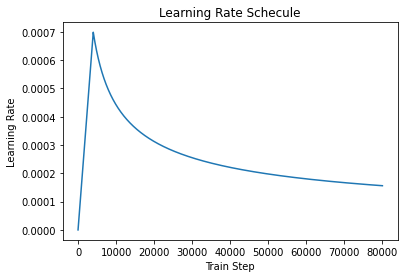

In [41]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(80000, dtype=tf.float32)))
plt.title("Learning Rate Schecule")
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [42]:
# Loss and Metrics
# reduction value "none" has to start with lower case letter
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, 
                                                            reduction="none")

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_sum(loss_) / tf.reduce_sum(mask)

In [43]:
sample_real = tf.constant([1, 2])
sample_pred = tf.constant([[0.7, 11, 0.9],
                           [2,5,7]])
print(loss_function(sample_real, sample_pred))

sample_real = tf.constant([1, 2, 0])
sample_pred = tf.constant([[0.7, 11, 0.9],
                           [2,5,7],
                           [100, 11, 120]])
print(loss_function(sample_real, sample_pred))

tf.Tensor(0.066460006, shape=(), dtype=float32)
tf.Tensor(0.066460006, shape=(), dtype=float32)


In [44]:
train_loss = tf.keras.metrics.Mean(name="train_loss")
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name="train_accuracy")

In [47]:
# Training and Checkpointing
transformer = Transformer(num_layers,
                          d_model,
                          num_heads,
                          dff,
                          input_vocab_size,
                          target_vocab_size,
                          pe_input=input_vocab_size,
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

def create_masks(inp, tar):
  # Encode padding mask
  enc_padding_mask = create_padding_mask(inp)

  # Used in the 2nd attention block in the decoder.
  # this padding mask is used to mask the encoder outputs.
  dec_padding_mask = create_padding_mask(inp)

  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by
  # the decoder.
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  """tf.(math.)maximumx: it returns element-wise maximum
     >>> x= tf.constant([1, 1, 1, 0])
     >>> y = tf.constant([1, 0, 0, 0])
     >>> tf.math.maximum(x, y)
     <tf.Tensor: shape=(4,), dtype=int32, numpy=array([1, 1, 1, 0], dtype=int32)>
  """
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

  return enc_padding_mask, combined_mask, dec_padding_mask

checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, 
                                          checkpoint_path,
                                          max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print("Latest checkpoint restored!")

EPOCHS = 20

# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
                        tf.TensorSpec(shape=(None, None), dtype=tf.int64),
                        tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]

  enc_padding_mask, combined_mask, dec_padding_mask = create_mask(inp, tar_inp)

  with tf.GradientTape() as tape:
    predictions, _ = transformer(inp,
                                 tar_inp,
                                 True,
                                 enc_padding_mask,
                                 combined_mask,
                                 dec_padding_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

  train_loss(loss)
  train_accuracy(tar_real, predictions)

In [50]:
for epoch in range(EPOCHS):
  start = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()

  # inp: Japanese, tar: English
  for (batch, (inp, tar)) in enumerate(train_dataset):
    train_step(inp, tar)

    if batch % 100 == 0:
      print("Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}".format(epoch+1,
                                                                   batch,
                                                                   train_loss.result(),
                                                                   train_accuracy.result()))
    
  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print("Saving checkpoint for epoch {} at {}".format(epoch+1,
                                                        ckpt_save_path))
  
  print("Epoch {} Loss {:.4f} Accuracy {:.4f}".format(epoch+1,
                                                      train_loss.result(),
                                                      train_accuracy.result()))
  
  print("Time taken for 1 epoch: {} secs\n".format(time.time - start))

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([1, 1, 1, 0], dtype=int32)>